<a href="https://colab.research.google.com/github/yang-song/score_sde_pytorch/blob/main/Score_SDE_demo_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

1. `git clone https://github.com/yang-song/score_sde_pytorch.git`

2. Install [required packages](https://github.com/yang-song/score_sde_pytorch/blob/main/requirements.txt)

3. `cd` into folder `score_sde_pytorch`, launch a local jupyter server and connect to colab following [these instructions](https://research.google.com/colaboratory/local-runtimes.html)

4. Download pre-trained [checkpoints](https://drive.google.com/drive/folders/1tFmF_uh57O6lx9ggtZT_5LdonVK2cV-e?usp=sharing) and save them in the `exp` folder.

In [1]:
!nvidia-smi

Tue Feb 21 10:47:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   31C    P0    37W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!CUDA_LAUNCH_BLOCKING=1

In [3]:
#@title Autoload all modules
#%load_ext autoreload
#%autoreload 2

from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
#import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics,
                      AnnealedLangevinDynamicsOld)

import datasets

/home/g4merz/.conda/envs/astrodetclone/lib/python3.9/site-packages/torch/utils/cpp_extension.py:295: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(
/home/g4merz/.conda/envs/astrodetclone/lib/python3.9/site-packages/torch/utils/cpp_extension.py:295: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
from models import ncsnv2
#importlib.reload(models)
#importlib.reload(ncsnv2)
#from models import ncsnv2


In [6]:
# @title Load the score-based model
sde_str = 'VESDE' #@param ['VESDE', 'VPSDE', 'subVPSDE'] {"type": "string"}
if sde_str.lower() == 'vesde':
    from configs.ve import cifar10_ncsnpp_continuous as configs
    ckpt_filename = "exp/ve/cifar10_ncsnpp_continuous/checkpoint_24.pth"
    config = configs.get_config()  
    sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
    sampling_eps = 1e-5

elif sde_str.lower() == 'vesde_old':
    from configs.ve.ncsnv2 import cifar10 as configs
    ckpt_filename = "ncsnv2/exp/logs/cifar10/best_checkpoint_with_denoising.pth"
    config = configs.get_config()  
    sde = VESDE(sigma_max=config.model.sigma_max, N=config.model.num_scales)
    sampling_eps = 1e-5
 
    
#elif sde.lower() == 'vpsde':
#    from configs.vp import cifar10_ddpmpp_continuous as configs  
#    ckpt_filename = "exp/vp/cifar10_ddpmpp_continuous/checkpoint_8.pth"
#    config = configs.get_config()
#    sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
#    sampling_eps = 1e-3
#elif sde.lower() == 'subvpsde':
#    from configs.subvp import cifar10_ddpmpp_continuous as configs
#    ckpt_filename = "exp/subvp/cifar10_ddpmpp_continuous/checkpoint_26.pth"
#    config = configs.get_config()
#    sde = subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
#    sampling_eps = 1e-3

batch_size =   36#@param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)

score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)
if not sde_str.lower() == 'vesde_old':
    state = restore_checkpoint(ckpt_filename, state, config.device)
    ema.copy_to(score_model.parameters())

In [35]:
from models.ema import EMAHelper


In [36]:
states = torch.load(ckpt_filename, map_location=config.device)

score_model.load_state_dict(states[0], strict=True)
ema=True
if ema:
    ema_helper = EMAHelper(mu=config.model.ema_rate)
    ema_helper.register(score_model)
    ema_helper.load_state_dict(states[-1])
    ema_helper.ema(score_model)



In [7]:
#@title Visualization code

def image_grid(x):
    size = config.data.image_size
    channels = config.data.num_channels
    img = x.reshape(-1, size, size, channels)
    w = int(np.sqrt(img.shape[0]))
    img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
    return img

def show_samples(x):
    x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
    img = image_grid(x)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

def show_samples_subplot(x,ax):
    x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
    img = image_grid(x)
    ax.axis('off')
    ax.imshow(img)
    #plt.show()
    

# Predictor Corrector sampling


Recommended settings:

 | dataset | SDE | predictor | corrector | snr | n_steps |
|:----:|:----:|:----------:|:--------:|:---:|:----:|
|CIFAR-10 | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.16| 1|
|CIFAR-10 | VP | EulerMaruyamaPredictor | None | - | - |
|CIFAR-10 | subVP| EulerMaruyamaPredictor | None | - | - |
| LSUN/CelebA-HQ/FFHQ 256px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.075 | 1 |
| FFHQ 1024px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.15| 1 |

Check `probability_flow` to run PC sampling based on discretizing the probability flow ODE.

In [10]:
sig = get_sigmas(config)
sig = torch.Tensor(sig).cuda()

used_sigmas = sig[labels].view(x.shape[0], *([1] * len(x.shape[1:])))
print(used_sigmas.shape)

torch.Size([36, 1, 1, 1])


In [57]:
import importlib
importlib.reload(sampling)
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics,
                      AnnealedLangevinDynamicsOld)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


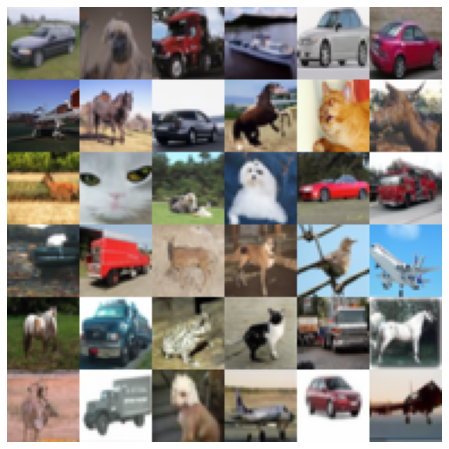

CPU times: user 2min 5s, sys: 21.8 s, total: 2min 27s
Wall time: 2min 26s


In [10]:
%%time
#@title PC sampling
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps =  1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
sampling_fn = sampling.get_pc_sampler(sde, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device)

#sampling_fn = sampling.get_old_pc_sampler(sde, shape, predictor, corrector,
#                                      inverse_scaler, snr, n_steps=n_steps,
#                                      probability_flow=probability_flow,
#                                      continuous=config.training.continuous,
#                                      eps=sampling_eps, device=config.device)


x, n = sampling_fn(score_model)
show_samples(x)

# Probability flow ODE

With black-box ODE solvers, we can produce samples, compute likelihoods, and obtain a uniquely identifiable encoding of any data point.

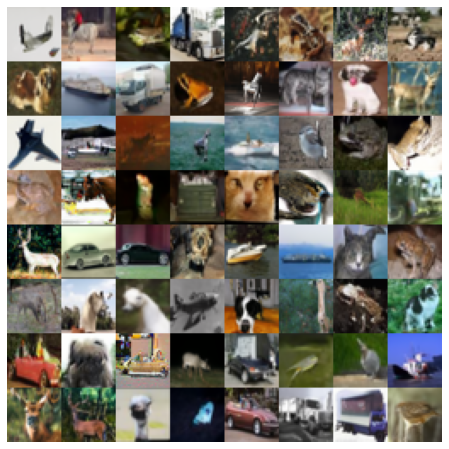

In [ ]:
 #@title ODE sampling

shape = (batch_size, 3, 32, 32)
sampling_fn = sampling.get_ode_sampler(sde,                                        
                                       shape, 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps,
                                       device=config.device)
x, nfe = sampling_fn(score_model)
show_samples(x)

In [ ]:
#@title Likelihood computation
train_ds, eval_ds, _ = datasets.get_dataset(config, uniform_dequantization=True, evaluation=True)
eval_iter = iter(eval_ds)
bpds = []
likelihood_fn = likelihood.get_likelihood_fn(sde,                                              
                                             inverse_scaler,                                             
                                             eps=1e-5)
for batch in eval_iter:
  img = batch['image']._numpy()
  img = torch.tensor(img).permute(0, 3, 1, 2).to(config.device)
  img = scaler(img)
  bpd, z, nfe = likelihood_fn(score_model, img)
  bpds.extend(bpd)
  print(f"average bpd: {torch.tensor(bpds).mean().item()}, NFE: {nfe}")

In [ ]:
#@title Representations
train_ds, eval_ds, _ = datasets.get_dataset(config, uniform_dequantization=False, evaluation=True)
eval_batch = next(iter(eval_ds))
eval_images = eval_batch['image']._numpy()
shape = (batch_size, 3, 32, 32)

likelihood_fn = likelihood.get_likelihood_fn(sde, inverse_scaler, eps=1e-5)
sampling_fn = sampling.get_ode_sampler(sde, shape, inverse_scaler,
                                       denoise=True, eps=sampling_eps, device=config.device)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image_grid(eval_images))
plt.title('Original images')

eval_images = torch.from_numpy(eval_images).permute(0, 3, 1, 2).to(config.device)
_, latent_z, _ = likelihood_fn(score_model, scaler(eval_images))

x, nfe = sampling_fn(score_model, latent_z)

x = x.permute(0, 2, 3, 1).cpu().numpy()
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image_grid(x))
plt.title('Reconstructed images')

# Controllable generation

Several demonstrations on how to solve inverse problems with our SDE framework.

Recommended settings

| dataset | SDE | predictor | corrector | snr | n_steps |
|:----:|:----:|:----------:|:--------:|:---:|:----:|
|CIFAR-10 | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.16| 1|
|CIFAR-10 | VP | EulerMaruyamaPredictor | None | - | - |
|CIFAR-10 | subVP| EulerMaruyamaPredictor | None | - | - |
| LSUN/CelebA-HQ/FFHQ 256px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.075 | 1 |
| FFHQ 1024px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.15| 1 |

In [ ]:
%%time

#@title PC inpainting

train_ds, eval_ds, _ = datasets.get_dataset(config)
eval_iter = iter(eval_ds)
bpds = []

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

pc_inpainter = controllable_generation.get_pc_inpainter(sde,
                                                        predictor, corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)

batch = next(eval_iter)
img = batch['image']._numpy()
img = torch.from_numpy(img).permute(0, 3, 1, 2).to(config.device)
show_samples(img)

mask = torch.ones_like(img)
mask[:, :, :, 16:] = 0.
show_samples(img * mask)


x = pc_inpainter(score_model, scaler(img), mask)
show_samples(x)

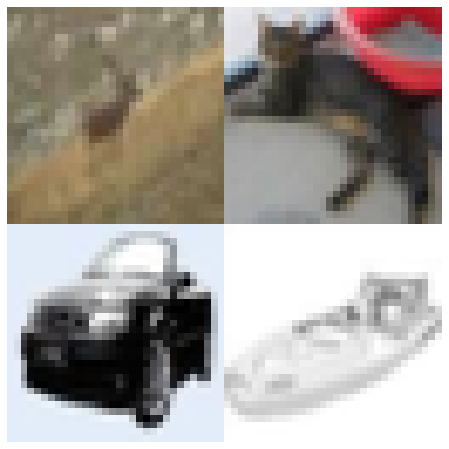

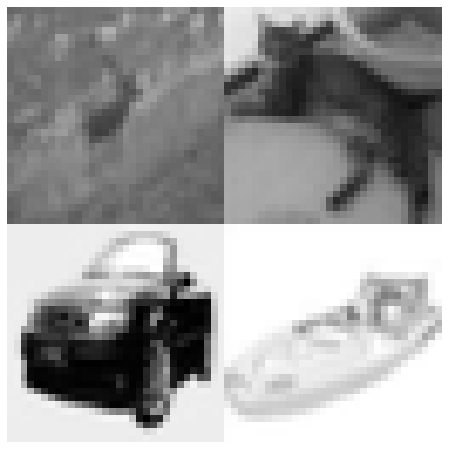

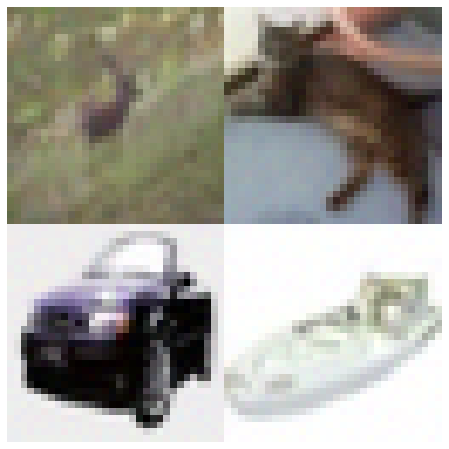

In [18]:
#@title PC colorizer
train_ds, eval_ds, _ = datasets.get_dataset(config)
eval_iter = iter(eval_ds)
bpds = []

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
#corrector = AnnealedLangevinDynamics
snr = 0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

batch = next(eval_iter)
img = batch['image']._numpy()
img = torch.from_numpy(img).permute(0, 3, 1, 2).to(config.device)
show_samples(img)
gray_scale_img = torch.mean(img, dim=1, keepdims=True).repeat(1, 3, 1, 1)
show_samples(gray_scale_img)
gray_scale_img = scaler(gray_scale_img)
pc_colorizer = controllable_generation.get_pc_colorizer(
    sde, predictor, corrector, inverse_scaler,
    snr=snr, n_steps=n_steps, probability_flow=probability_flow,
    continuous=config.training.continuous, denoise=True
)
x = pc_colorizer(score_model, gray_scale_img)

show_samples(x)

## Source separation

In [49]:
import importlib
import sampling
importlib.reload(sampling)
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import controllable_generation_copy


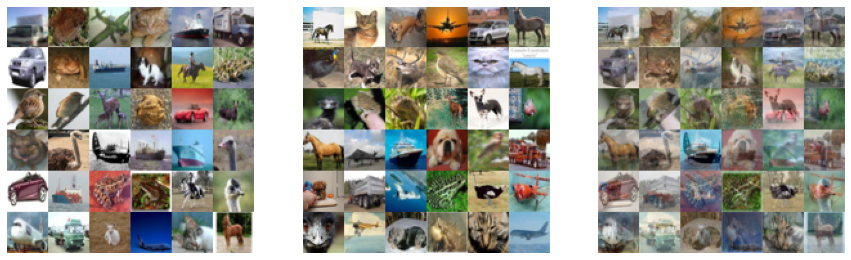

In [101]:

#@title PC colorizer
train_ds, eval_ds, _ = datasets.get_dataset(config)
eval_iter = iter(eval_ds)
bpds = []

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = AnnealedLangevinDynamics #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
#snr = 0.16 #@param {"type": "number"}
snr = 0.4
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

batch1 = next(eval_iter)
img1 = batch1['image']._numpy()
img1 = torch.from_numpy(img1).permute(0, 3, 1, 2).to(config.device)

batch2 = next(eval_iter)
img2 = batch2['image']._numpy()
img2 = torch.from_numpy(img2).permute(0, 3, 1, 2).to(config.device)


mixed = torch.Tensor(sum([img1.cpu(),img2.cpu()])).cuda().view(batch_size, 3, 32, 32)

fig,ax = plt.subplots(1,3,figsize=(15,5))
show_samples_subplot(img1,ax[0])
show_samples_subplot(img2,ax[1])
show_samples_subplot(mixed/2,ax[2])



#gray_scale_img = torch.mean(img, dim=1, keepdims=True).repeat(1, 3, 1, 1)
#show_samples(gray_scale_img)
#gray_scale_img = scaler(gray_scale_img)
#pc_colorizer = controllable_generation.get_pc_colorizer(
#    sde, predictor, corrector, inverse_scaler,
#    snr=snr, n_steps=n_steps, probability_flow=probability_flow,
#    continuous=config.training.continuous, denoise=True
#)
#x = pc_colorizer(score_model, gray_scale_img)

#show_samples(x)

In [151]:
import importlib
import controllable_generation_copy
importlib.reload(controllable_generation_copy)
import controllable_generation_copy

In [152]:
snr=0.3

In [154]:
%%time
mixed_scale_img = scaler(mixed)
pc_separator = controllable_generation_copy.get_mixture_conditional_sampler(
    sde, predictor, corrector, inverse_scaler,
    snr=snr, n_steps=1, probability_flow=probability_flow,
    continuous=config.training.continuous, denoise=True,M=100
)
x1,x2 = pc_separator(score_model, mixed_scale_img)

#show_samples(x)

CPU times: user 2min 2s, sys: 22.1 s, total: 2min 24s
Wall time: 2min 24s


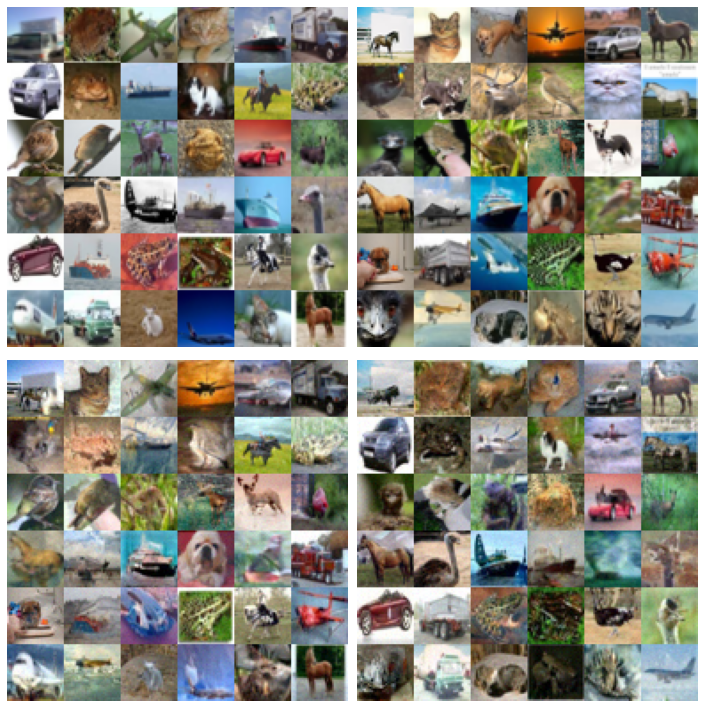

In [155]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
show_samples_subplot(img1,ax[0][0])
show_samples_subplot(img2,ax[0][1])
show_samples_subplot(x1,ax[1][0])
show_samples_subplot(x2,ax[1][1])
plt.tight_layout()

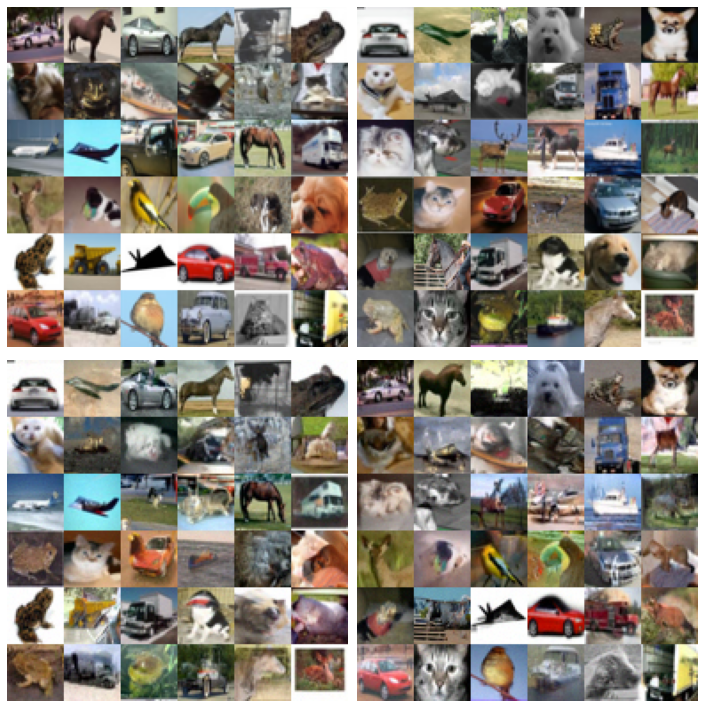

In [70]:
# M=100, every 20th scale
fig,ax = plt.subplots(2,2,figsize=(10,10))
show_samples_subplot(img1,ax[0][0])
show_samples_subplot(img2,ax[0][1])
show_samples_subplot(x1,ax[1][0])
show_samples_subplot(x2,ax[1][1])
plt.tight_layout()

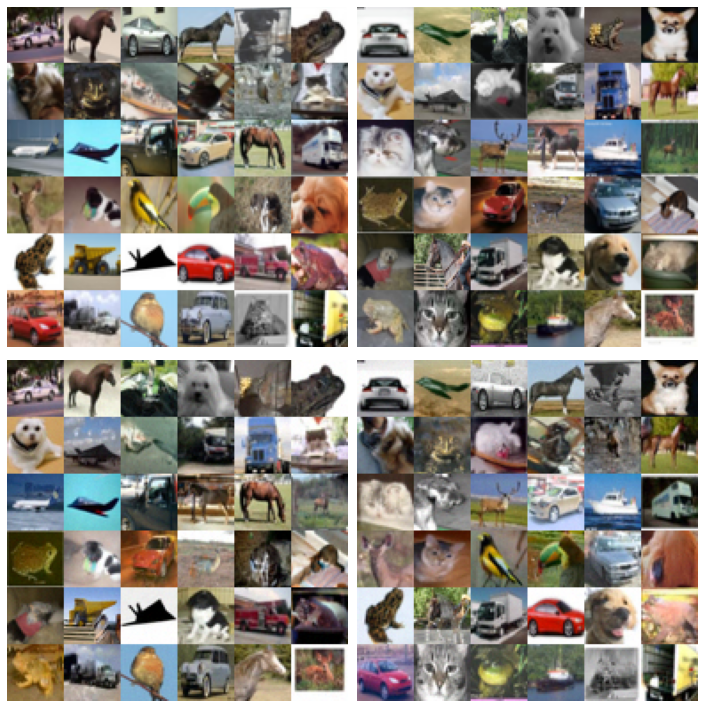

In [62]:
#M=100, every 10th scale
fig,ax = plt.subplots(2,2,figsize=(10,10))
show_samples_subplot(img1,ax[0][0])
show_samples_subplot(img2,ax[0][1])
show_samples_subplot(x1,ax[1][0])
show_samples_subplot(x2,ax[1][1])
plt.tight_layout()

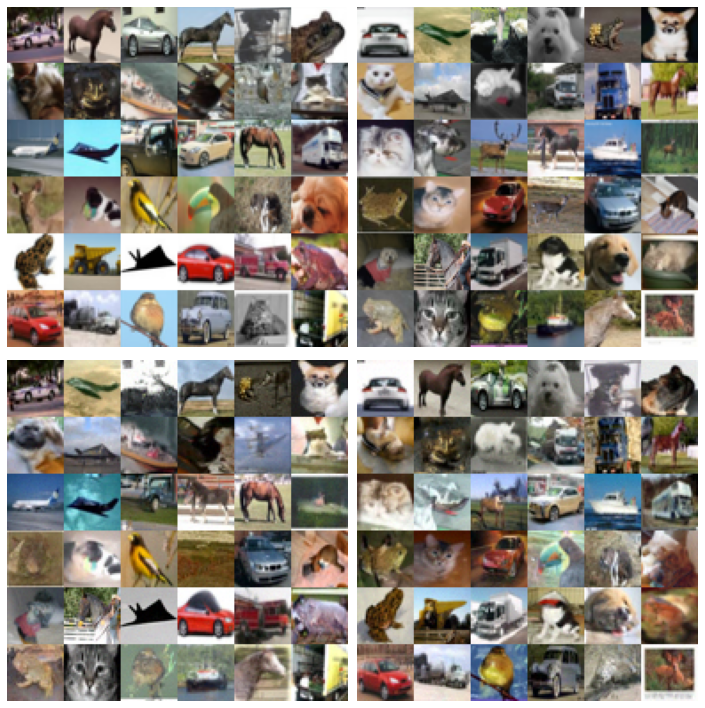

In [60]:
#M=50, every 10th scale
fig,ax = plt.subplots(2,2,figsize=(10,10))
show_samples_subplot(img1,ax[0][0])
show_samples_subplot(img2,ax[0][1])
show_samples_subplot(x1,ax[1][0])
show_samples_subplot(x2,ax[1][1])
plt.tight_layout()

## Class-conditional generation



Check out the [class-conditional generation section](https://colab.research.google.com/drive/1dRR_0gNRmfLtPavX2APzUggBuXyjWW55#scrollTo=HiYRNB-Wk329&line=3&uniqifier=1) in our [JAX demo](https://colab.research.google.com/drive/1dRR_0gNRmfLtPavX2APzUggBuXyjWW55?usp=sharing)